In [102]:
import tensorflow as tf

In [103]:
import numpy as np

In [104]:
tf.__version__

'1.13.1'

# Operations

In [105]:
class Operation():
    def __init__(self, input_nodes = []):
        self.input_nodes = input_nodes
        self.output_nodes = []
        
        for node in input_nodes:
            node.output_nodes.append(self)
        
        _default_graph.operations.append(self)
        
   # def compute(self):
   #     """
   #         This is a placeholder function. It will be overwritten by the actural function that inherits from this class
   #     """
   #     pass

## Addition

In [106]:
class add(Operation):
    def __init__(self, x, y):
        super().__init__([x, y])
    def compute(self, x_var, y_var):
        self.inputs = [x_var, y_var]
        return x_var + y_var

## Multiplication

In [107]:
class multiply(Operation):
    def __init__(self, a, b):
        super().__init__([a, b])
    def compute(self, x_var, y_var):
        self.inputs = [x_var, y_var]
        return x_var*y_var

## Matrix Multiplication

In [108]:
class matmul(Operation):
    def __init__(self, a, b):
        super().__init__([a, b])
    def compute(self, a_mat, b_mat):
        self.inputs = [a_mat, b_mat]
        return a_mat.dot(b_mat)

## Placeholders

In [109]:
class Placeholder():
    """
        A placeholder is a node that needs to be provided a value for computing the output in a graph
    """
    def __init__(self):
        self.output_nodes = []
        _default_graph.placeholders.append(self)
        

## Variables

In [110]:
class Variable():
    """
       Variable is a changeable parameter of the Graph
    """
    def __init__(self, initial_value = None):
        self.value = initial_value
        self.output_nodes = []
        
        _default_graph.variables.append(self)

## Graph

In [111]:
class Graph():
    def __init__(self):
        self.operations = []
        self.placeholders = []
        self.variables = []
    def set_as_default(self):
        """
            Set this graph as the default global graph
        """
        global _default_graph
        _default_graph = self
        

## A basic example

$$z = Ax+b$$
With A=10, and b = 1
$$z = 10x+1$$
Just need a placeholder for x and then once x is filled we can solve it!

In [112]:
g = Graph()

In [113]:
g.set_as_default()

In [114]:
A = Variable(10)

In [115]:
b = Variable(1)

In [116]:
#create a placeholder for x and fill it later
x = Placeholder()

In [117]:
y = add(multiply(A, x), b)

## Session

In [118]:
import numpy as np

### Traversing operation nodes

In [125]:
def traverse_postorder(operation):
    """ 
    PostOrder Traversal of Nodes. Basically makes sure computations are done in 
    the correct order (Ax first , then Ax + b). Feel free to copy and paste this code.
    It is not super important for understanding the basic fundamentals of deep learning.
    """
    
    nodes_postorder = []
    def recurse(node):
        if isinstance(node, Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append(node)

    recurse(operation)
    return nodes_postorder

In [119]:
class Session:
    
    def run(self, operation, feed_dict = {}):
        """ 
          operation: The operation to compute
          feed_dict: Dictionary mapping placeholders to input values (the data)  
        """
        
        # Puts nodes in correct order
        nodes_postorder = traverse_postorder(operation)
        
        for node in nodes_postorder:

            if type(node) == Placeholder:
                
                node.output = feed_dict[node]
                
            elif type(node) == Variable:
                
                node.output = node.value
                
            else: # Operation
                
                node.inputs = [input_node.output for input_node in node.input_nodes]

                 
                node.output = node.compute(*node.inputs)
                
            # Convert lists to numpy arrays
            if type(node.output) == list:
                node.output = np.array(node.output)
        
        # Return the requested node value
        return operation.output

In [120]:
sess = Session()

In [126]:
result = sess.run(operation=y, feed_dict = {x:10})

In [127]:
result

101

## Another example with matrix multiplication

In [143]:
g = Graph()

In [151]:
g.set_as_default()

In [152]:
A = Variable([[10, 20], [30, 40]])
b = Variable([[1, 2], [3, 4]])

In [153]:
x = Placeholder()
y = add(matmul(A, x), b)

In [154]:
sess = Session()

In [155]:
result = sess.run(y, {x:[[1, 2], [3, 4]]})

In [156]:
result

array([[ 71, 102],
       [153, 224]])

## Activation Function

In [157]:
import matplotlib.pyplot as plt

In [158]:
def sigmoid(z):
    return 1.0/(1+np.exp(-z))

In [161]:
sample_z = np.linspace(-10, 10, 100)
sample_a = sigmoid(sample_z)

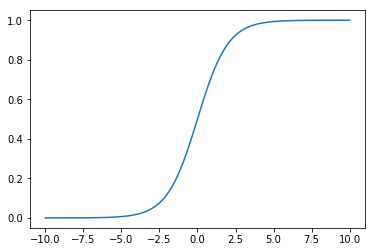

In [162]:
plt.plot(sample_z, sample_a)

### Sigmoid as an operation

In [163]:
class Sigmoid(Operation):
    def __init__(self, z):
        super().__init__([z])
    def compute (self, z_val):
        return 1.0/(1+np.exp(-z_val))

## Classification Example

In [164]:
from sklearn.datasets import make_blobs

In [171]:
data = make_blobs(n_samples=50, n_features=2, centers=2, random_state=101)

In [178]:
print (data[0][:4], '\n\n', data[1][:4]) #coordinates, and classes

[[  0.85678605   0.8243512 ]
 [  2.482819     0.80309288]
 [-10.47729501  -5.2768023 ]
 [ -8.76419615  -7.1078015 ]] 

 [0 0 1 1]


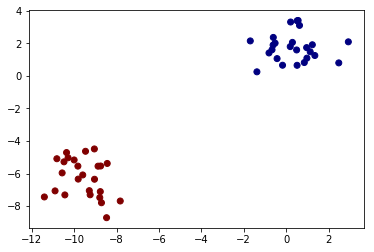

In [190]:
plt.scatter(data[0][:, 0], data[0][:, 1], c=data[1], cmap='jet')
#cmap = 'viridis', or 'viridis_r', or ...

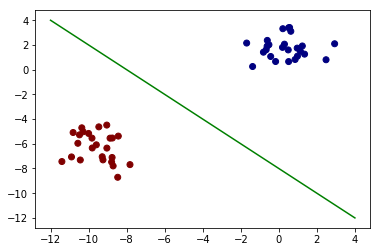

In [196]:
#draw a line that separtes the two classes
x = np.linspace(-12, 4, 10)
y = -x -8
plt.scatter(data[0][:, 0], data[0][:, 1], c=data[1], cmap='jet')
plt.plot(x, y, 'g')


From this plot, we can see that function z = x+y+8 is positive above the line, and negative below the line. With such z, sigmoid function is > 0.5 above line, and < 0.5 below the line. Thus we can use such function to classify points.

## Defining the perceptron

In [197]:
g = Graph()

In [198]:
g.set_as_default()

In [200]:
x = Placeholder()

In [201]:
w = Variable([1, 1])

In [202]:
b = Variable(8)

In [203]:
z = add(matmul(w, x), b)

In [204]:
a = Sigmoid(z)

In [205]:
sess = Session()

In [206]:
sess.run(a, {x:[0, 4]})

0.9999938558253978

In [208]:
sess.run(a, {x:[-10, -6]})

0.0003353501304664781

From the above two instances, we can see that Sigmoid function does a good job in giving out the probability of the class to which a point belongs.